# (extended) elastic impedance

_Last update: August 2018, added extended elastic impedance code and various helper functions._

Connolly introduced the concept of elastic impedance ($EI$) in 1999 as an elegant solution to tie the interpretation of far angle stacks to well data (near-offsets can be tied to well data through simple acoustic impedance).

He rearranged the Aki-Richards equations so that the output is not reflectivity but something like a proper log, which is strikingly similar in shape to acoustic impedance ($AI$), until something interesting happens (like a hydrocarbon-bearing sand) and then elastic impedance shows a different response from $AI$.

The formula looks like this:

$$ EI = V_p^a V_s^b \rho^c $$

where:

$$ a = 1 + \tan^2 \theta $$
$$ b = -8 k \sin^2 \theta $$
$$ c = 1 - 4 k \sin^2 \theta $$
$$ k = \left( \frac{V_s}{V_p} \right)^2 $$

The $k$ factor is usually kept constant in a given area.

Connolly also presents an alternative form which "can be used for generating synthetics" (his own words, check the Appendix in Connolly, 1999):
    
$$ EI = V_p \rho^* $$
$$ \rho^\ast = V_p^{(\tan^2 \theta)} V_s^b \rho^c ) $$

In practice we have $EI$ expressed as the product of velocity and a pseudo-density ($ \rho^* $) that is angle-dependant. So any kind of 1D modeling can be used to generate angle-dependant synthetic seismograms, and the usual calibration of $ V_p $ through time-depth tables ensures the correct positioning in time. 

Whitcome in 2002 introduced the normalized $EI$ function to allow comparisons between $EI$ logs calculated at different angles:

$$ EI^{NORM} = \rho_0 V_{p0} \, \left[ \left( \frac{V_p}{V_{p0}}\right)^a  \left( \frac{V_s}{V_{s0}} \right)^b  \left( \frac{\rho}{\rho_0} \right)^c\right]$$


Where the scaling factors $V_{p0}$ $V_{s0}$ $\rho_0$ are averages of the input elastic logs computed over the range of interest or the values at the top of the target zone.
 
I discuss some practical aspects of using elastic impedance in the context of generating synthetic seismograms and also show how I reproduced a couple of figures from "Seismic Amplitude" by Simm & Bacon in this notebook here: ["The relationship between reflectivity and elastic impedance", or how to reproduce figure 5.62 from Seismic Amplitude by Simm & Bacon (2014)](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/relationship-reflectivity-elastic-impedance_Simm-Bacon.ipynb).

## references

* Connolly, 1999, Elastic impedance, The Leading Edge.
* Connolly, 2017, Chi, in 79th EAGE Conference and Exhibition 2017.
* Simm & Bacon, 2014, Seismic Amplitude: An Interpreter's Handbook, Cambridge University Press.
* Thomas, Ball, Blangy, and Davids, 2013, Quantitative analysis aspects of the EEI correlation method, SEG Abstracts.
* Whitcombe, Connolly, Reagan, Redshow, 2002, Extended elastic impedance for fluid and lithology prediction, Geophysics.
* Whitcombe, 2002, Elastic impedance normalization, Geophysics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import detrend

from ipywidgets import interact, fixed
import ipywidgets as widgets

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

In [2]:
def calc_ei(vp, vs, rho, alpha, scal=None, k=0.25):
    alpha = np.radians(alpha)
    a = 1 + (np.tan(alpha)) ** 2
    b = -8 * k * ((np.sin(alpha)) ** 2)
    c = 1 - 4 * k * ((np.sin(alpha)) ** 2)
    if scal is None:
        ei = vp**a * vs**b * rho** c
    else:
        vp0, vs0, rho0 = scal[0], scal[1], scal[2]
        ei = vp0*rho0 * ( (vp/vp0) ** a * (vs/vs0) ** b * (rho/rho0) ** c)
    return ei

In [3]:
w2=pd.read_csv('qsiwell2_frm.csv', index_col=0)

z1, z2 = 2100, 2150
ff = (w2.index>=z1) & (w2.index<=z2)
scal=w2.VP[ff].mean(), w2.VS[ff].mean(), w2.RHO[ff].mean()
ei = calc_ei(w2.VP, w2.VS, w2.RHO,30)
ei_norm = calc_ei(w2.VP, w2.VS, w2.RHO,30,scal)

gr = w2.GR
ip = w2.VP * w2.RHO
z = w2.index.values

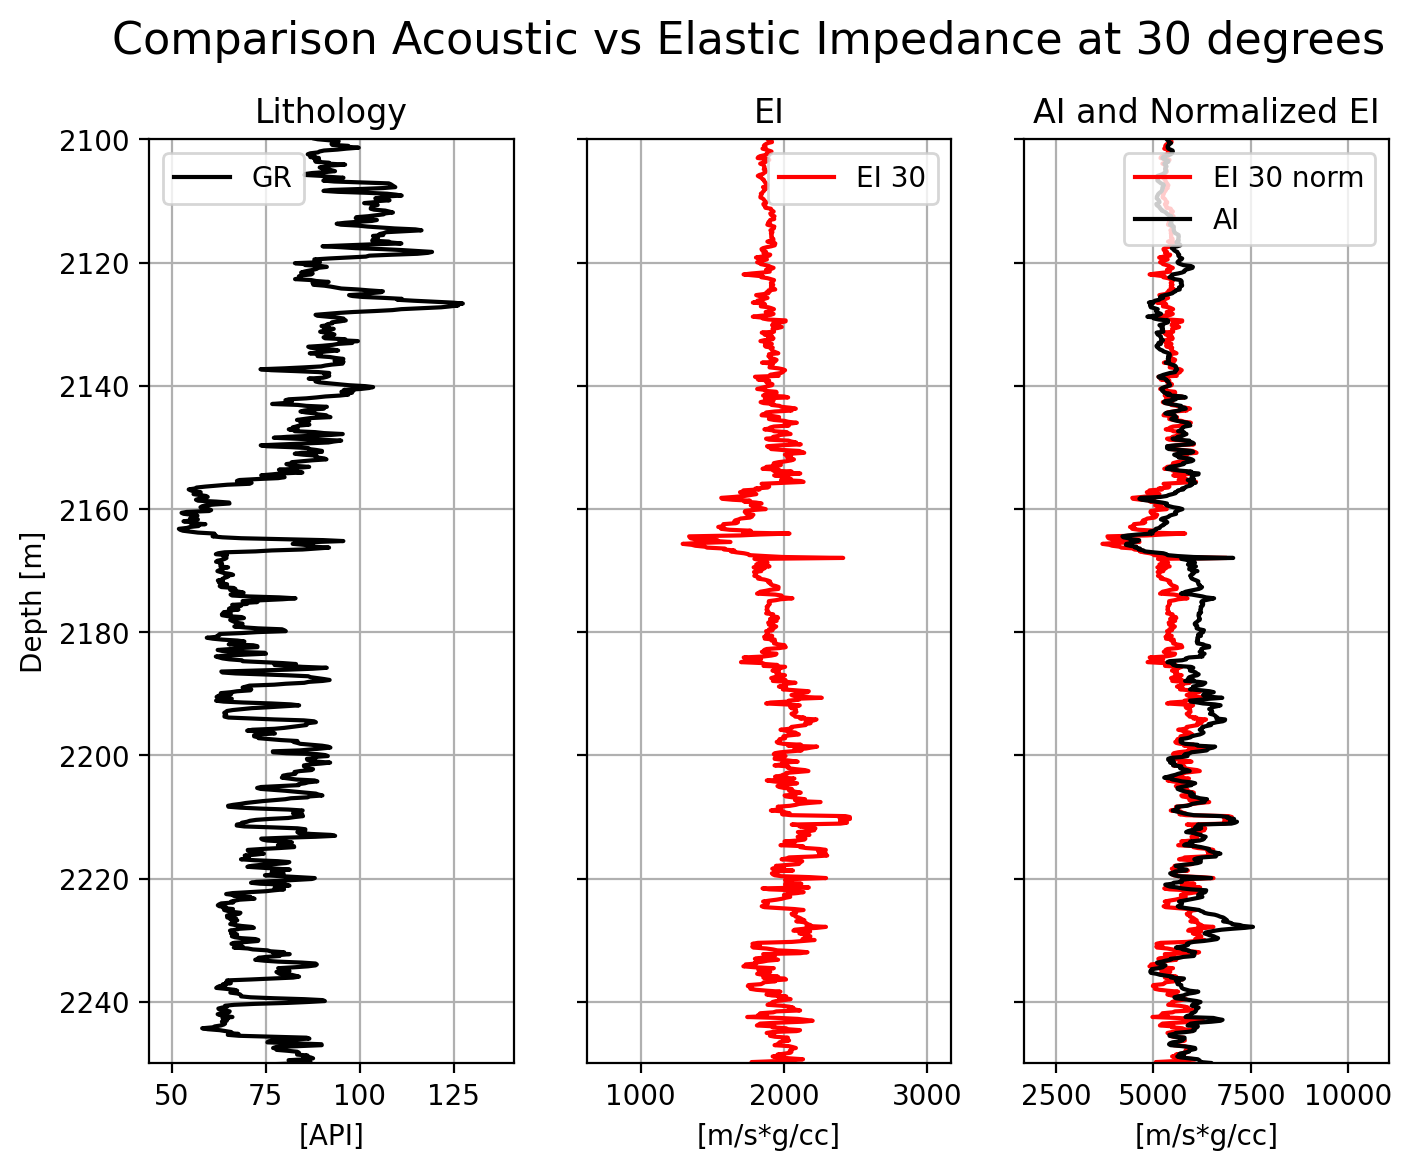

In [4]:
f, ax = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(8,6))
ax[0].plot(gr,z,'k', label='GR')
ax[1].plot(ei,z,'r', label='EI 30')
ax[2].plot(ei_norm,z,'r', label='EI 30 norm')
ax[2].plot(ip,z,'k', label='AI')

ax[0].set_ylim(2250,2100)
ax[0].set_xlabel('[API]')
ax[1].set_xlabel('[m/s*g/cc]')
ax[2].set_xlabel('[m/s*g/cc]')
ax[0].set_ylabel('Depth [m]')
ax[1].locator_params(nbins=5, axis='x')
for aa in ax:
    aa.grid(which='both')
    aa.legend()
ax[0].set_title('Lithology')
ax[1].set_title('EI')
ax[2].set_title('AI and Normalized EI')
f.suptitle('Comparison Acoustic vs Elastic Impedance at 30 degrees', fontsize=16);

## How to calculate EI in commercial software

Just as an additional (and potentially useful) piece of information, here's how you would specify the constants discussed above ($k$ plus the scaling factors $V_{p0}$ $V_{s0}$ $\rho_0$) in the well-tie module ("Well Seismic Fusion") in Halliburton's Decision Space:

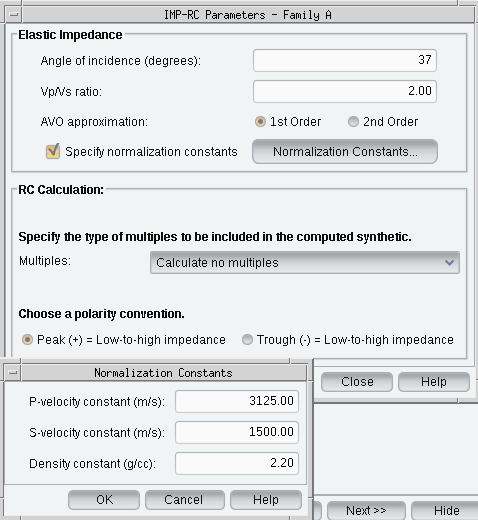

In [5]:
from IPython.display import Image
Image(filename='DecisionSpace_welltie_EI_Calc.png', width=400)

I haven't found further details on this but it looks like that you have indeed to specify the _Vp/Vs ratio_ and not the $k$ constant, so given $Vp/Vs = 2$ then $ k = (Vs/Vp)^2 = 0.25 $.

The _normalization constants_ are those that I call scaling factors.

## extended elastic impedance

In [12]:
def calc_eei(vp, vs, rho, chi, scal=None, k=0.25):
    '''
    EI (C) aadm 2018
    extended elastic impedance
    '''
    chi = np.radians(chi)
    p = np.cos(chi) + np.sin(chi)
    q = -8 * k * np.sin(chi)
    r = np.cos(chi) - 4 * k * np.sin(chi)
    if scal is None:
        vp0, vs0, rho0 = np.nanmean(vp), np.nanmean(vs), np.nanmean(rho)
    else:
        vp0, vs0, rho0 = scal[0], scal[1], scal[2]
    eei = vp0*rho0 * ( (vp/vp0) ** p * (vs/vs0) ** q * (rho/rho0) ** r)
    return eei

def eei_scaling(wells,names,tops,start,window,brine=False):
    tmp0=np.zeros((len(wells),3))
    tmp1=np.zeros((len(wells)))
    if brine:
        idvp,idvs,idrho,fluidtype=['VP_FRMB','VS_FRMB','RHO_FRMB','brine']
    else:
        idvp,idvs,idrho,fluidtype=['VP','VS','RHO','insitu']
    for i,ww in enumerate(wells):
        z1 = tops[names[i]][start]
        z2 = tops[names[i]][start]+window
        ww = ww.loc[(ww.index>=z1) & (ww.index<=z2)]
        k = (np.nanmean(ww[idvs]) / np.nanmean(ww[idvp])) ** 2  # avg over interval of interest
        scal=np.nanmean(np.column_stack((ww[idvp], ww[idvs], ww[idrho])), axis=0)
        tmp0[i,:]=scal
        tmp1[i]=k
        print('{:.<12s} vp0={:<6.0f} vs0={:<6.0f} rho0={:<6.2f} vp/vs={:<6.2f} k={:<6.2f} ({:s})'.format(names[i],scal[0],scal[1],scal[2],(1/k)**.5,k,fluidtype))
    vp0,vs0,rho0=tmp0.mean(axis=0)
    k0=tmp1.mean()
    print('{:.<12s} vp0={:<6.0f} vs0={:<6.0f} rho0={:<6.2f} vp/vs={:<6.2f} k={:<6.2f} ({:s})'.format('[AVG]',vp0,vs0,rho0,(1/k0)**.5,k0,fluidtype))
    return tmp0.mean(axis=0),tmp1.mean()

def eei_diagnostic(ww,ztop,zbot,scal=None,k=None,ln=False,chi_min=None,chi_max=None,brine=False,targetlog='GR',removetrend=False,name=None):
    label_eei = 'EEI'
    if ln:
        label_eei = 'ln('+label_eei+')'
    if brine:
        idvp,idvs,idrho=['VP_FRMB','VS_FRMB','RHO_FRMB']
    else:
        idvp,idvs,idrho=['VP','VS','RHO']
    ww = ww.loc[(ww.index>=ztop) & (ww.index<=zbot)]
    ww = ww.interpolate(limit_direction='both')
    if chi_min is None:
        chi_min, chi_max = -90,90
    chi=np.linspace(chi_min,chi_max)
    corr_eei = np.zeros(chi.size)
    eei_array = np.zeros((ww.index.size,chi.size))
    target=ww[targetlog]
    if k is None:
        k = (np.nanmean(ww[idvs]) / np.nanmean(ww[idvp]))**2
    if scal is None:
        scal = np.nanmean(np.column_stack((ww[idvp], ww[idvs], ww[idrho])), axis=0)
    for n,X in enumerate(chi):
        eei = calc_eei(ww[idvp],ww[idvs],ww[idrho],X,scal=scal,k=k)
        if ln:
            eei = np.log(eei)
        if removetrend:
            eei = pd.Series(data=detrend(eei), index=ww.index)
            target = pd.Series(data=detrend(target), index=ww.index)
        corr_eei[n]=target.corr(eei)
        eei_array[:,n]=eei.values
    maxcorr_eei=np.max(np.abs(corr_eei))
    maxcorr_eei_id=np.argmax(np.abs(corr_eei))
    print('max corr. EEI-{:s}={:.2f} @ X={:.0f}'.format(targetlog,maxcorr_eei,chi[maxcorr_eei_id]))
    fig = plt.subplots(figsize=(10,5))
    ax0 = plt.subplot2grid((1,5), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,5), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,5), (0,2), colspan=3)
    axtarget = ax0.twiny()
    axtarget.plot(target, ww.index, lw=1, color='.4')
    axtarget.set_xlabel(targetlog, color='0.4')
    axtarget.tick_params(axis='x', colors='0.4')
    axip = ax1.twiny()
    axip.plot(ww[idvp]*ww[idrho], ww.index, lw=1, color='black')
    axip.set_xlabel('Ip')
    ax2.plot(chi,corr_eei, ls='-', color='black')
    ax2.set_xlabel('CHI angle')
    ax2.set_ylabel('cross-correlation')
    ax2.grid()
    ax2.set_ylim(-1,1)
    ax2.set_xlim(chi.min(),chi.max())
    ax2.yaxis.set_label_position('right'), ax2.yaxis.tick_right()
    if removetrend:
        ax2.set_title('(de-trended)')
    ax0.set_ylabel('DEPTH (m MD)')
    ax1.set_yticklabels([])
    for aa in [ax0,ax1]:
        aa.plot(eei_array[:,maxcorr_eei_id], ww.index, lw=1, color='red')
        aa.set_xlabel('{:s}{:.0f}'.format(label_eei,chi[maxcorr_eei_id]), color='red')
        aa.tick_params(axis='x', colors='red')
        aa.set_ylim(zbot,ztop)
        aa.grid()
    if name is not None:
        plt.suptitle(name, weight='bold')
    return eei_array,corr_eei

def eei_optimalchi(wells,names,tops,start,window,scal,k,ln=False,chi_min=None,chi_max=None,brine=False,litholog='VSH',fluidlog='SWE',removetrend=False):
    label_eei = 'EEI'
    if ln:
        label_eei = 'ln('+label_eei+')'
    if removetrend:
        label_eei = 'de-trended '+label_eei
    if brine:
        idvp,idvs,idrho=['VP_FRMB','VS_FRMB','RHO_FRMB']
    else:
        idvp,idvs,idrho=['VP','VS','RHO']
    if chi_min is None:
        chi_min, chi_max = -90,90
    chi=np.linspace(chi_min,chi_max)
    corr_litho, corr_fluid = (np.zeros(chi.size) for _ in range(2))
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
    for i,ww in enumerate(wells):
        z1 = tops[names[i]][start]
        z2 = tops[names[i]][start]+window
        ww = ww.loc[(ww.index>=z1) & (ww.index<=z2)]
        ww = ww.interpolate(limit_direction='both')
        litho,fluid=ww[litholog],ww[fluidlog]
        for n,X in enumerate(chi):
            eei = calc_eei(ww[idvp],ww[idvs],ww[idrho],X,scal=scal,k=k)
            if ln:
                eei = np.log(eei)
            if removetrend:
                eei = pd.Series(data=detrend(eei), index=ww.index)
                litho = pd.Series(data=detrend(litho), index=ww.index)
                fluid = pd.Series(data=detrend(fluid), index=ww.index)
            corr_litho[n]=litho.corr(eei)
            corr_fluid[n]=fluid.corr(eei)
        maxcorr_litho = np.max(np.abs(corr_litho))
        maxcorr_litho_id=np.argmax(np.abs(corr_litho))
        maxcorr_fluid = np.max(np.abs(corr_fluid))
        maxcorr_fluid_id=np.argmax(np.abs(corr_fluid))
        print('{:s} Litho: max corr. EEI={:.2f} @ X={:.0f}'.format(names[i],maxcorr_litho,chi[maxcorr_litho_id]))
        print('{:s} Fluid: max corr. EEI={:.2f} @ X={:.0f}'.format(names[i],maxcorr_fluid,chi[maxcorr_fluid_id]))
        ax[0].plot(chi,corr_litho, label=names[i])
        ax[1].plot(chi,corr_fluid, label=names[i])
        ax[0].set_title('{}-{}'.format(label_eei,litholog))
        ax[1].set_title('{}-{}'.format(label_eei,fluidlog))
        for aa in ax:
            aa.grid()
            aa.set_xlabel('CHI angle'), aa.set_ylabel('cross-correlation')
            aa.legend()
            aa.set_ylim(-1,1)
        plt.tight_layout()

def eei_scanlogs(wells,names,tops,start,window,scal,k,ln=False,chi_min=None,chi_max=None,brine=False,litholog='VSH',fluidlog='SWE',removetrend=False):
    label_eei = 'EEI'
    if ln:
        label_eei = 'ln('+label_eei+')'
    if brine:
        idvp,idvs,idrho=['VP_FRMB','VS_FRMB','RHO_FRMB']
    else:
        idvp,idvs,idrho=['VP','VS','RHO']
    if chi_min is None:
        chi_min, chi_max = -90,90
    chi=np.linspace(chi_min,chi_max,10)
    corr_litho, corr_fluid = (np.zeros(chi.size) for _ in range(2))
    for i,ww in enumerate(wells):
        z1 = tops[names[i]][start]
        z2 = tops[names[i]][start]+window
        ww = ww.loc[(ww.index>=z1) & (ww.index<=z2)]
        ww = ww.interpolate(limit_direction='both')
        eei_array = np.zeros((ww.index.size,chi.size))
        litho,fluid=ww[litholog],ww[fluidlog]
        for n,X in enumerate(chi):
            eei = calc_eei(ww[idvp],ww[idvs],ww[idrho],X,scal=scal,k=k)
            if ln:
                eei = np.log(eei)
            if removetrend:
                eei = pd.Series(data=detrend(eei), index=ww.index)
                litho = pd.Series(data=detrend(litho), index=ww.index)
                fluid = pd.Series(data=detrend(fluid), index=ww.index)
            eei_array[:,n] = eei.values
        f,ax=plt.subplots(nrows=2,ncols=10,sharey=True,figsize=(12,8))
        for hh in range(10):
            ax[0,hh].set_xticklabels([])
            ax[1,hh].set_xlabel('{:s}{:.0f}'.format(label_eei,chi[hh]), color='red')
            axli = ax[0,hh].twiny()
            axli.plot(litho, ww.index, lw=1, color='0.4')
            axli.set_xlabel(litholog, color='0.4')
            axli.tick_params(axis='x', colors='0.4')
            axli.set_ylim(z2,z1)

            axfl = ax[1,hh].twiny()

            axfl.plot(fluid, ww.index, lw=1, color='blue')
            axfl.set_xlabel(fluidlog, color='blue')
            axfl.tick_params(axis='x', colors='blue')
            axfl.set_ylim(z2,z1)
            for n in range(2):
                ax[n,hh].plot(eei_array[:,hh], ww.index, lw=1, color='red')
                ax[n,hh].tick_params(axis='x', colors='red')
        ax[0,0].set_ylim(z2,z1)
        ax[0,0].set_ylabel('DEPTH (m MD)')
        ax[1,0].set_ylabel('DEPTH (m MD)')
        if removetrend:
            f.suptitle('{} (de-trended)'.format(names[i]))
        else:
            f.suptitle('{}'.format(names[i]))
        plt.subplots_adjust(hspace=.2,wspace=0.2,left=.05,right=.98)

## suggestions for a workflow

1. compute scaling coefficients
2. scan the entire $\chi$ angle range and calculate correlation coefficients for each angle between EEI log at that particular angle and target logs (where target logs are usually lithology e.g. VSH and fluid e.g. SW logs)
3. plot EEI against target logs and visually determine or crosscheck the results at point 2

### define stratigraphic markers

I will define some arbitrary markers to guide the interpretation (actually `top_sand` is the top of the Heimdal reservoir, as gathered from Quantitative Seismic Interpretation by Avseth et al., 2005).

In [13]:
wells= [ w2]
names= ['WELL_2']

In [14]:
tmp1={'top_shale': 2078, 'top_sand': 2153, 'owc': 2183, 'base_sand': 2250}
markers=pd.DataFrame.from_dict(tmp1, orient='index', columns=['WELL_2'])

In case of multiple wells I would add the markers for the other wells in this way and have a single Dataframe with all my stratigraphic markers. 

In [15]:
tmp2={'top_shale': 3000, 'top_sand': 3100, 'owc': 3130, 'base_sand': 3200}
dummy2=pd.DataFrame.from_dict(tmp2, orient='index', columns=['WELL_X'])
pd.concat([markers,dummy2],axis=1)

,WELL_2,WELL_X
top_shale,2078,3000
top_sand,2153,3100
owc,2183,3130
base_sand,2250,3200


In [16]:
scal0,k0=eei_scaling(wells,names,markers,'top_sand',200,brine=False)

WELL_2...... vp0=2951   vs0=1379   rho0=2.19   vp/vs=2.14   k=0.22   (insitu)
[AVG]....... vp0=2951   vs0=1379   rho0=2.19   vp/vs=2.14   k=0.22   (insitu)


WELL_2 Litho: max corr. EEI=0.44 @ X=57
WELL_2 Fluid: max corr. EEI=0.60 @ X=17


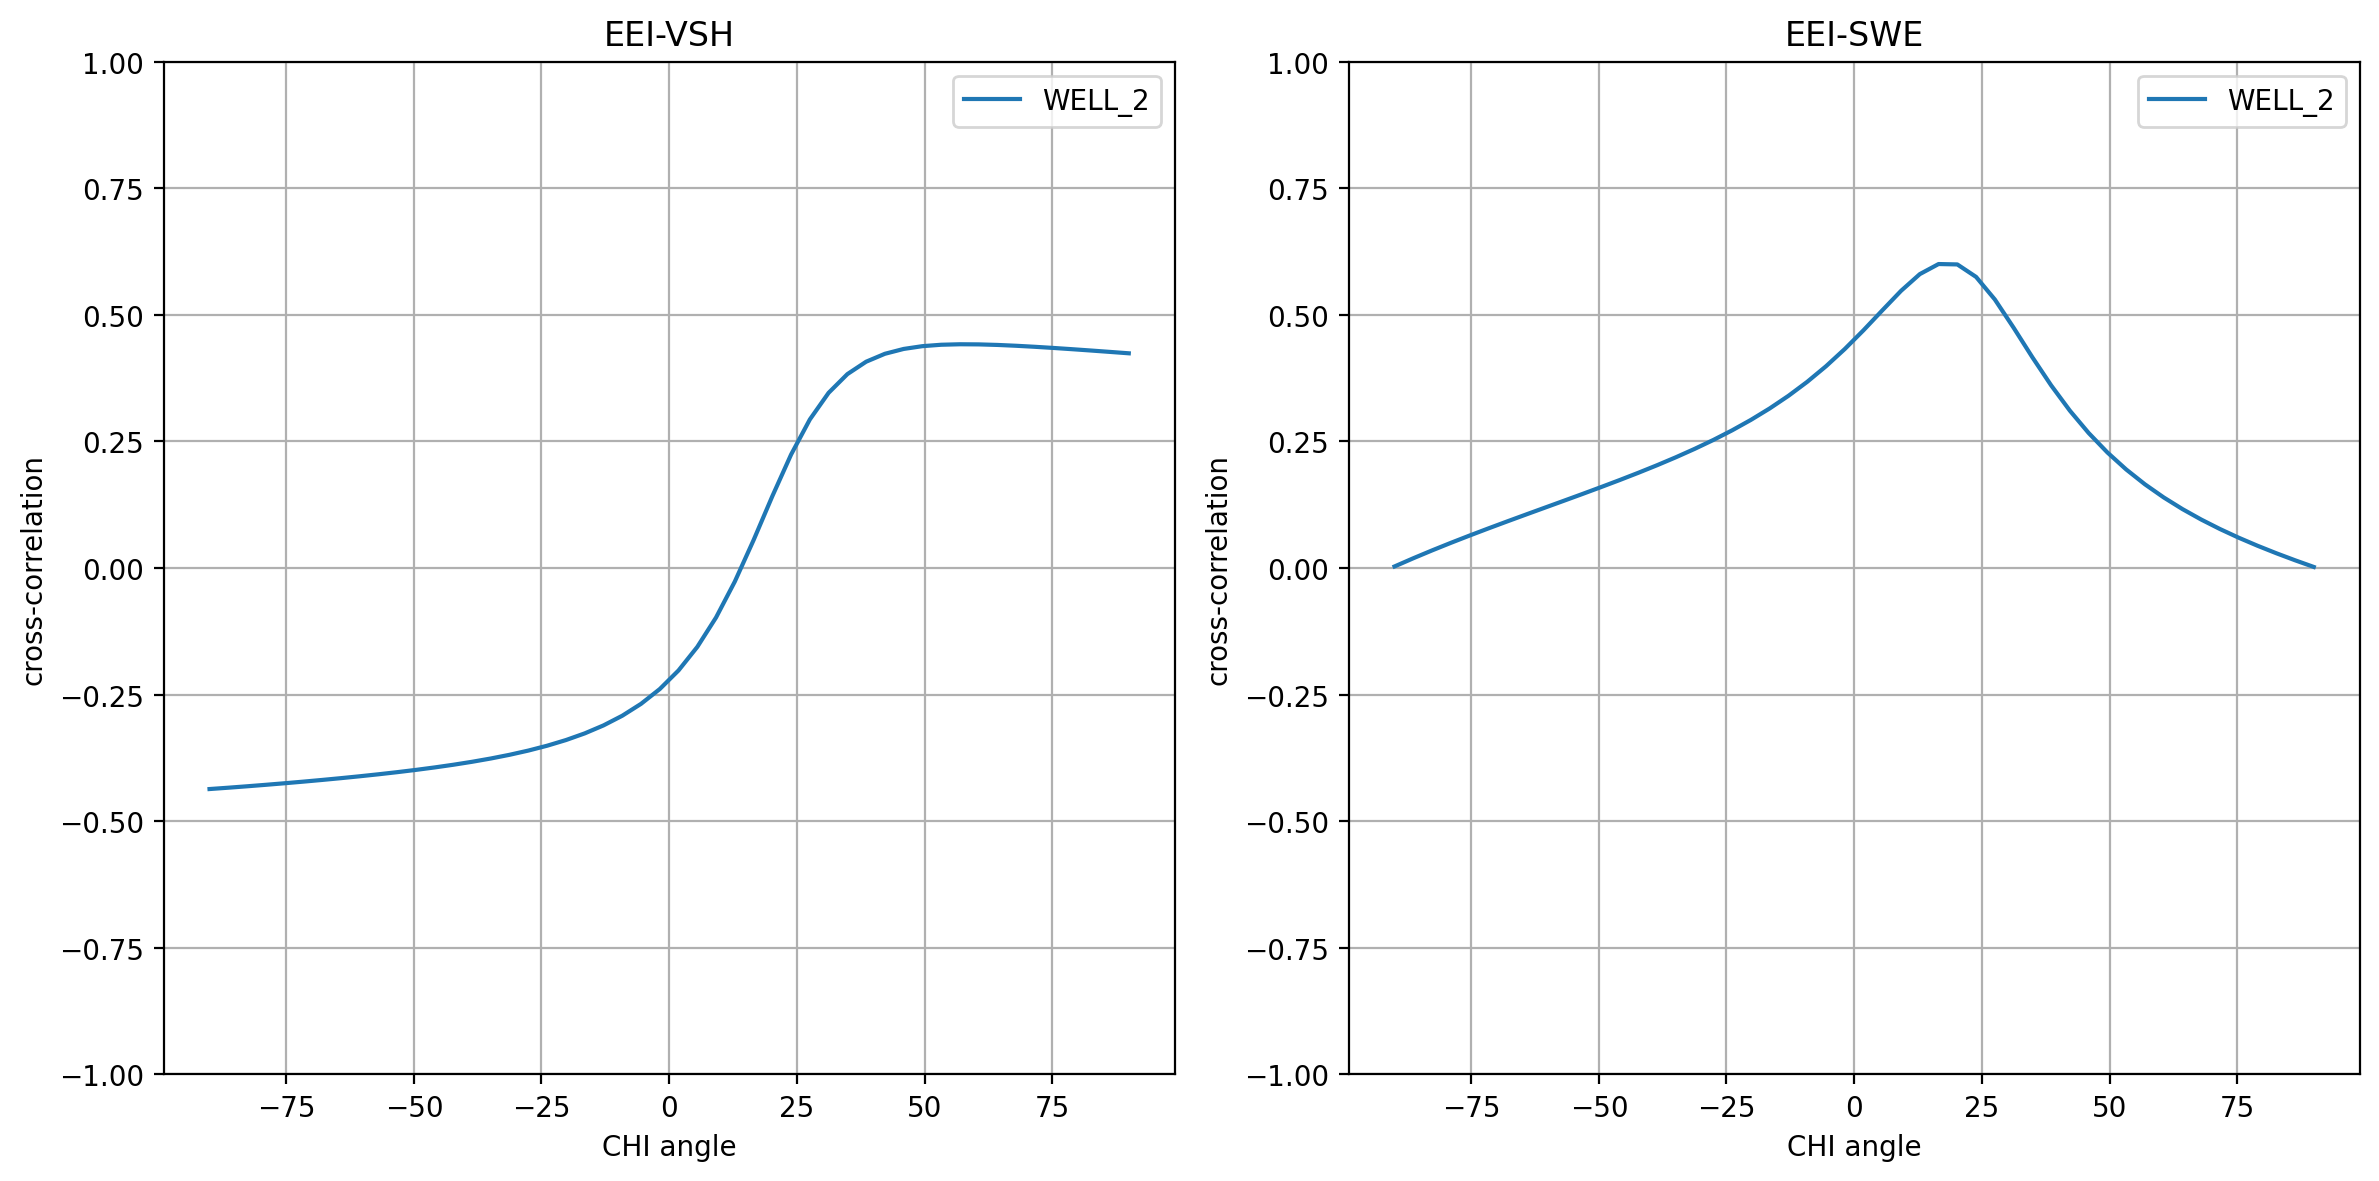

In [17]:
eei_optimalchi(wells,names,markers,'top_sand',200,scal0,k0,brine=False,removetrend=False)

Thomas & al. (2013) suggest to use the natural logarithm of EEI and perform the correlation analysis on the detrended target and logarithm-EEI curves.

From the quick tests I have run I think that detrending is effective only when using particularly long windows (how long? perhaps >100m?).

Also, the articles states to de-trend the target logs too, specifically mentioning that petrophsical logs _"will contain some trend"_. That may be the case if using a normal acquired log as target like GR for example, but I'm not so sure about water saturation and porosity logs calculated with some more accuracy. 

The following is an example of scanning for optimal $\chi$ angles using larger windows, using original, de-trended logs and ln(EEI):

input: EEI, trend removal=No
WELL_2 Litho: max corr. EEI=0.46 @ X=-121
WELL_2 Fluid: max corr. EEI=0.59 @ X=-151
input: EEI, trend removal=Yes
WELL_2 Litho: max corr. EEI=0.41 @ X=-114
WELL_2 Fluid: max corr. EEI=0.47 @ X=-136
input: ln(EEI), trend removal=Yes
WELL_2 Litho: max corr. EEI=0.41 @ X=62
WELL_2 Fluid: max corr. EEI=0.46 @ X=-143


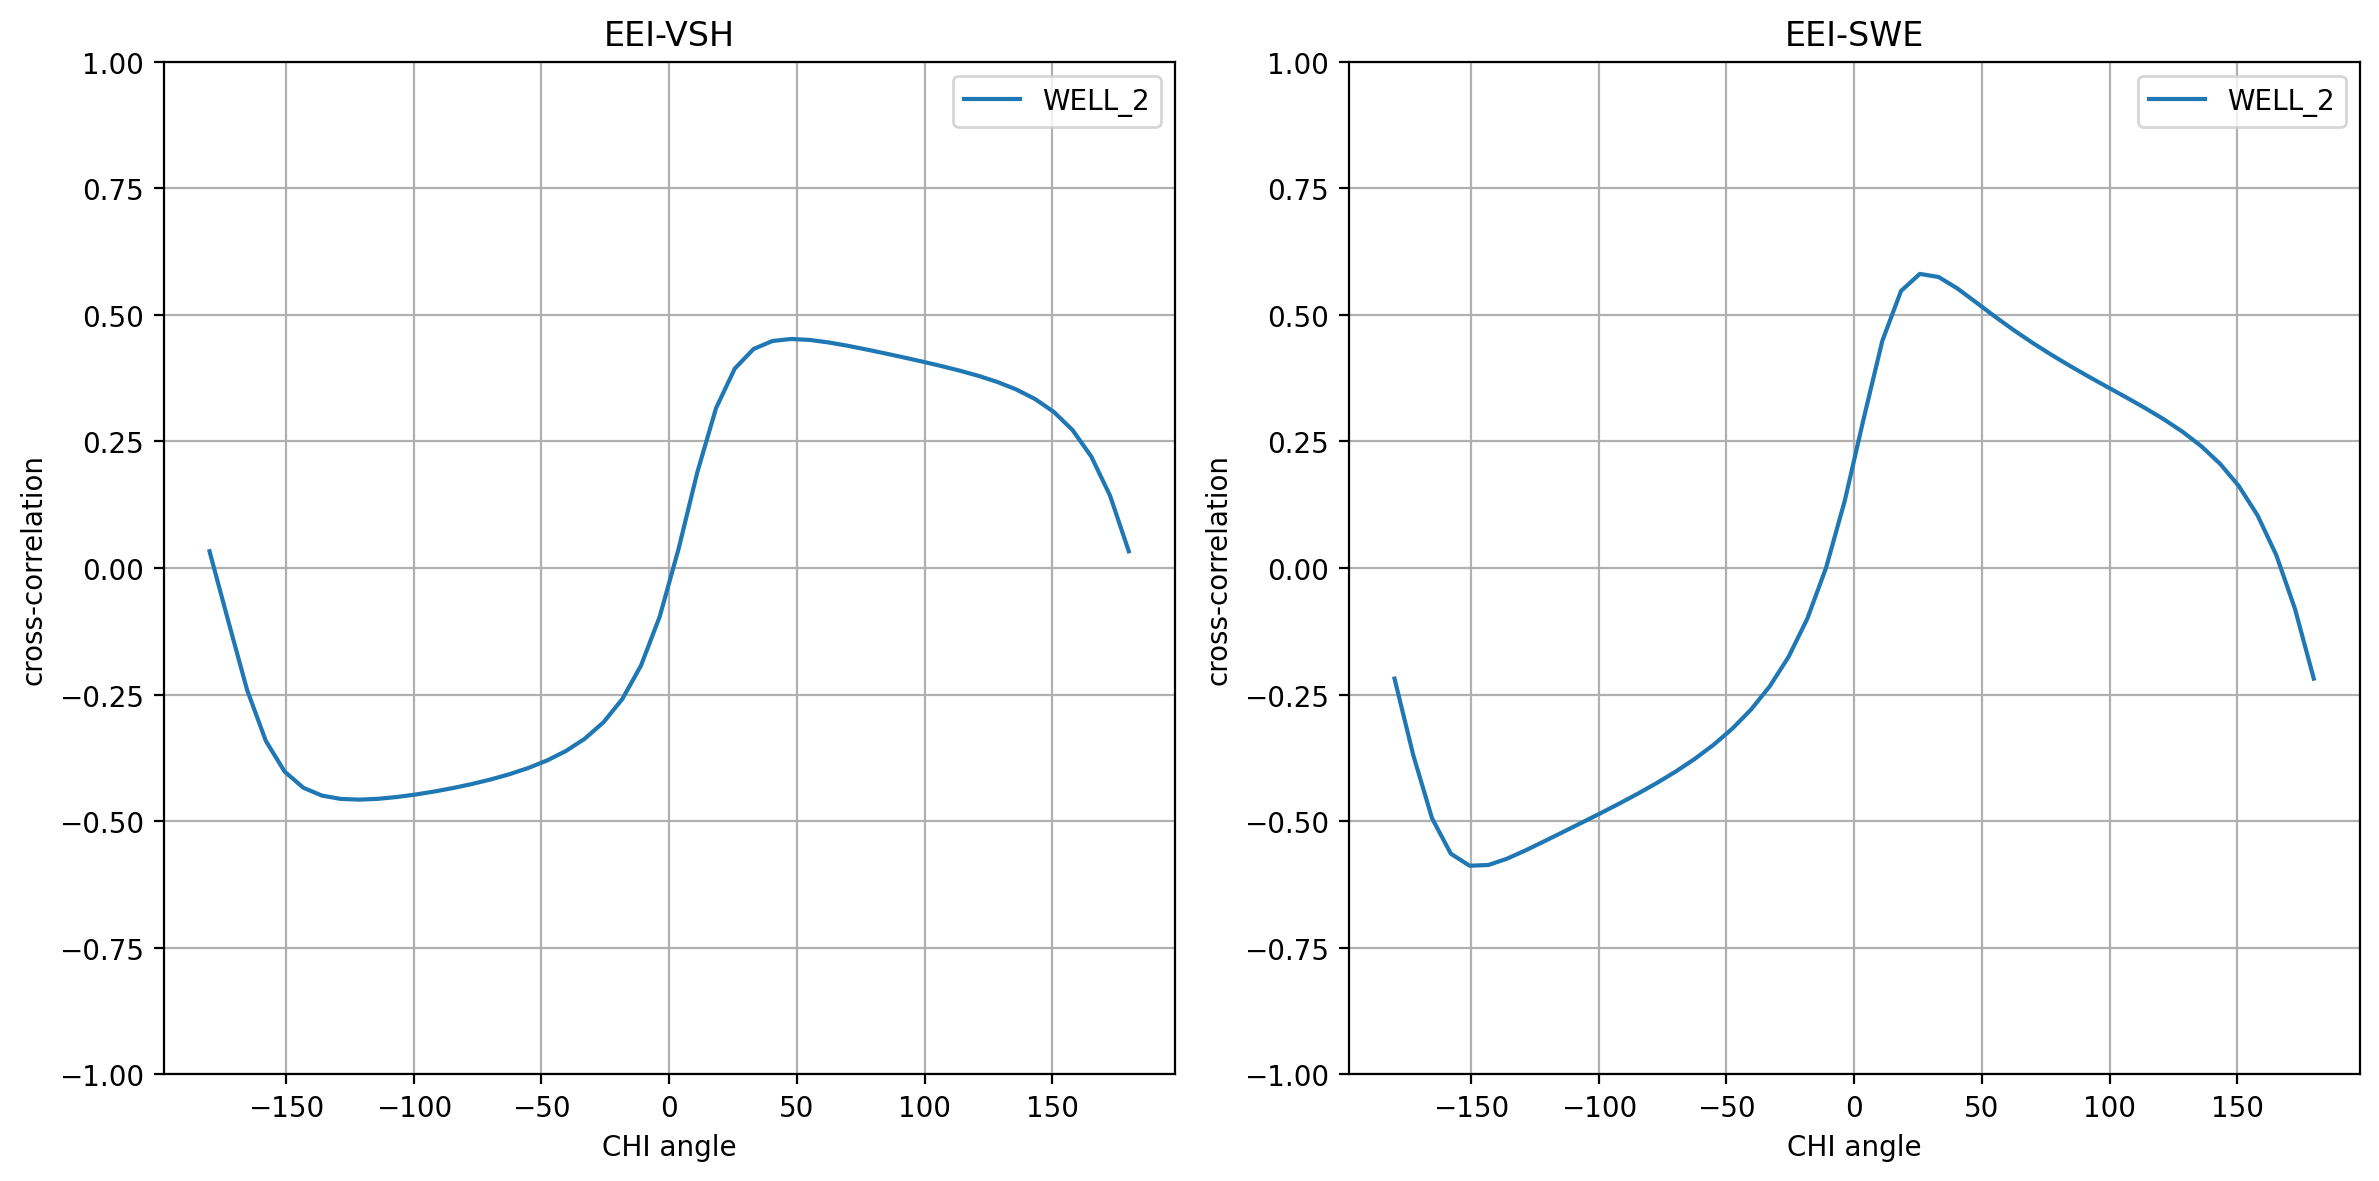

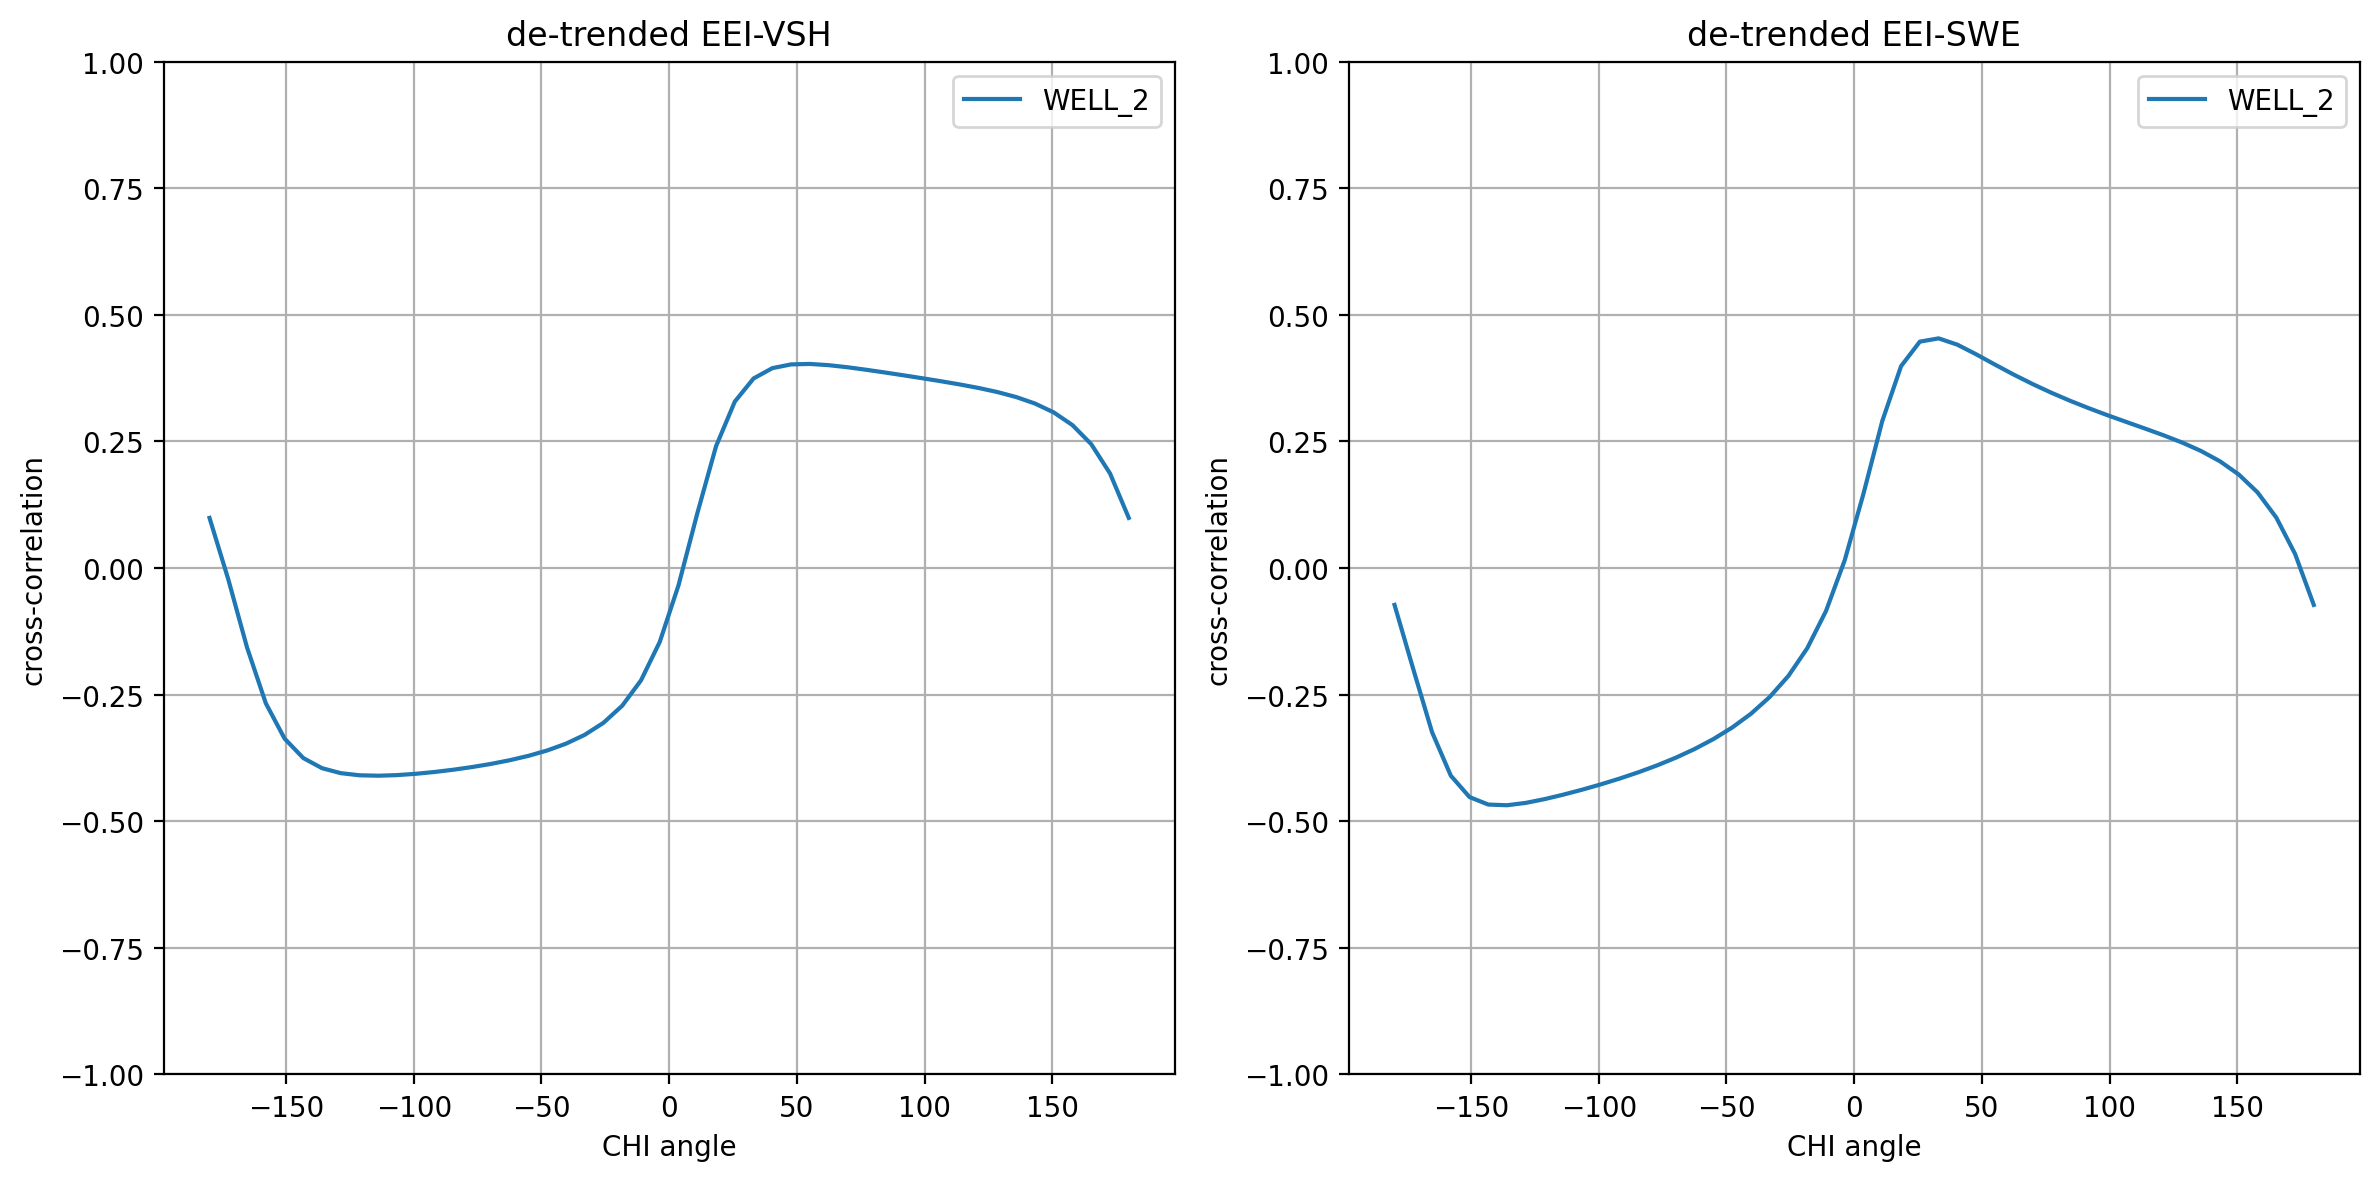

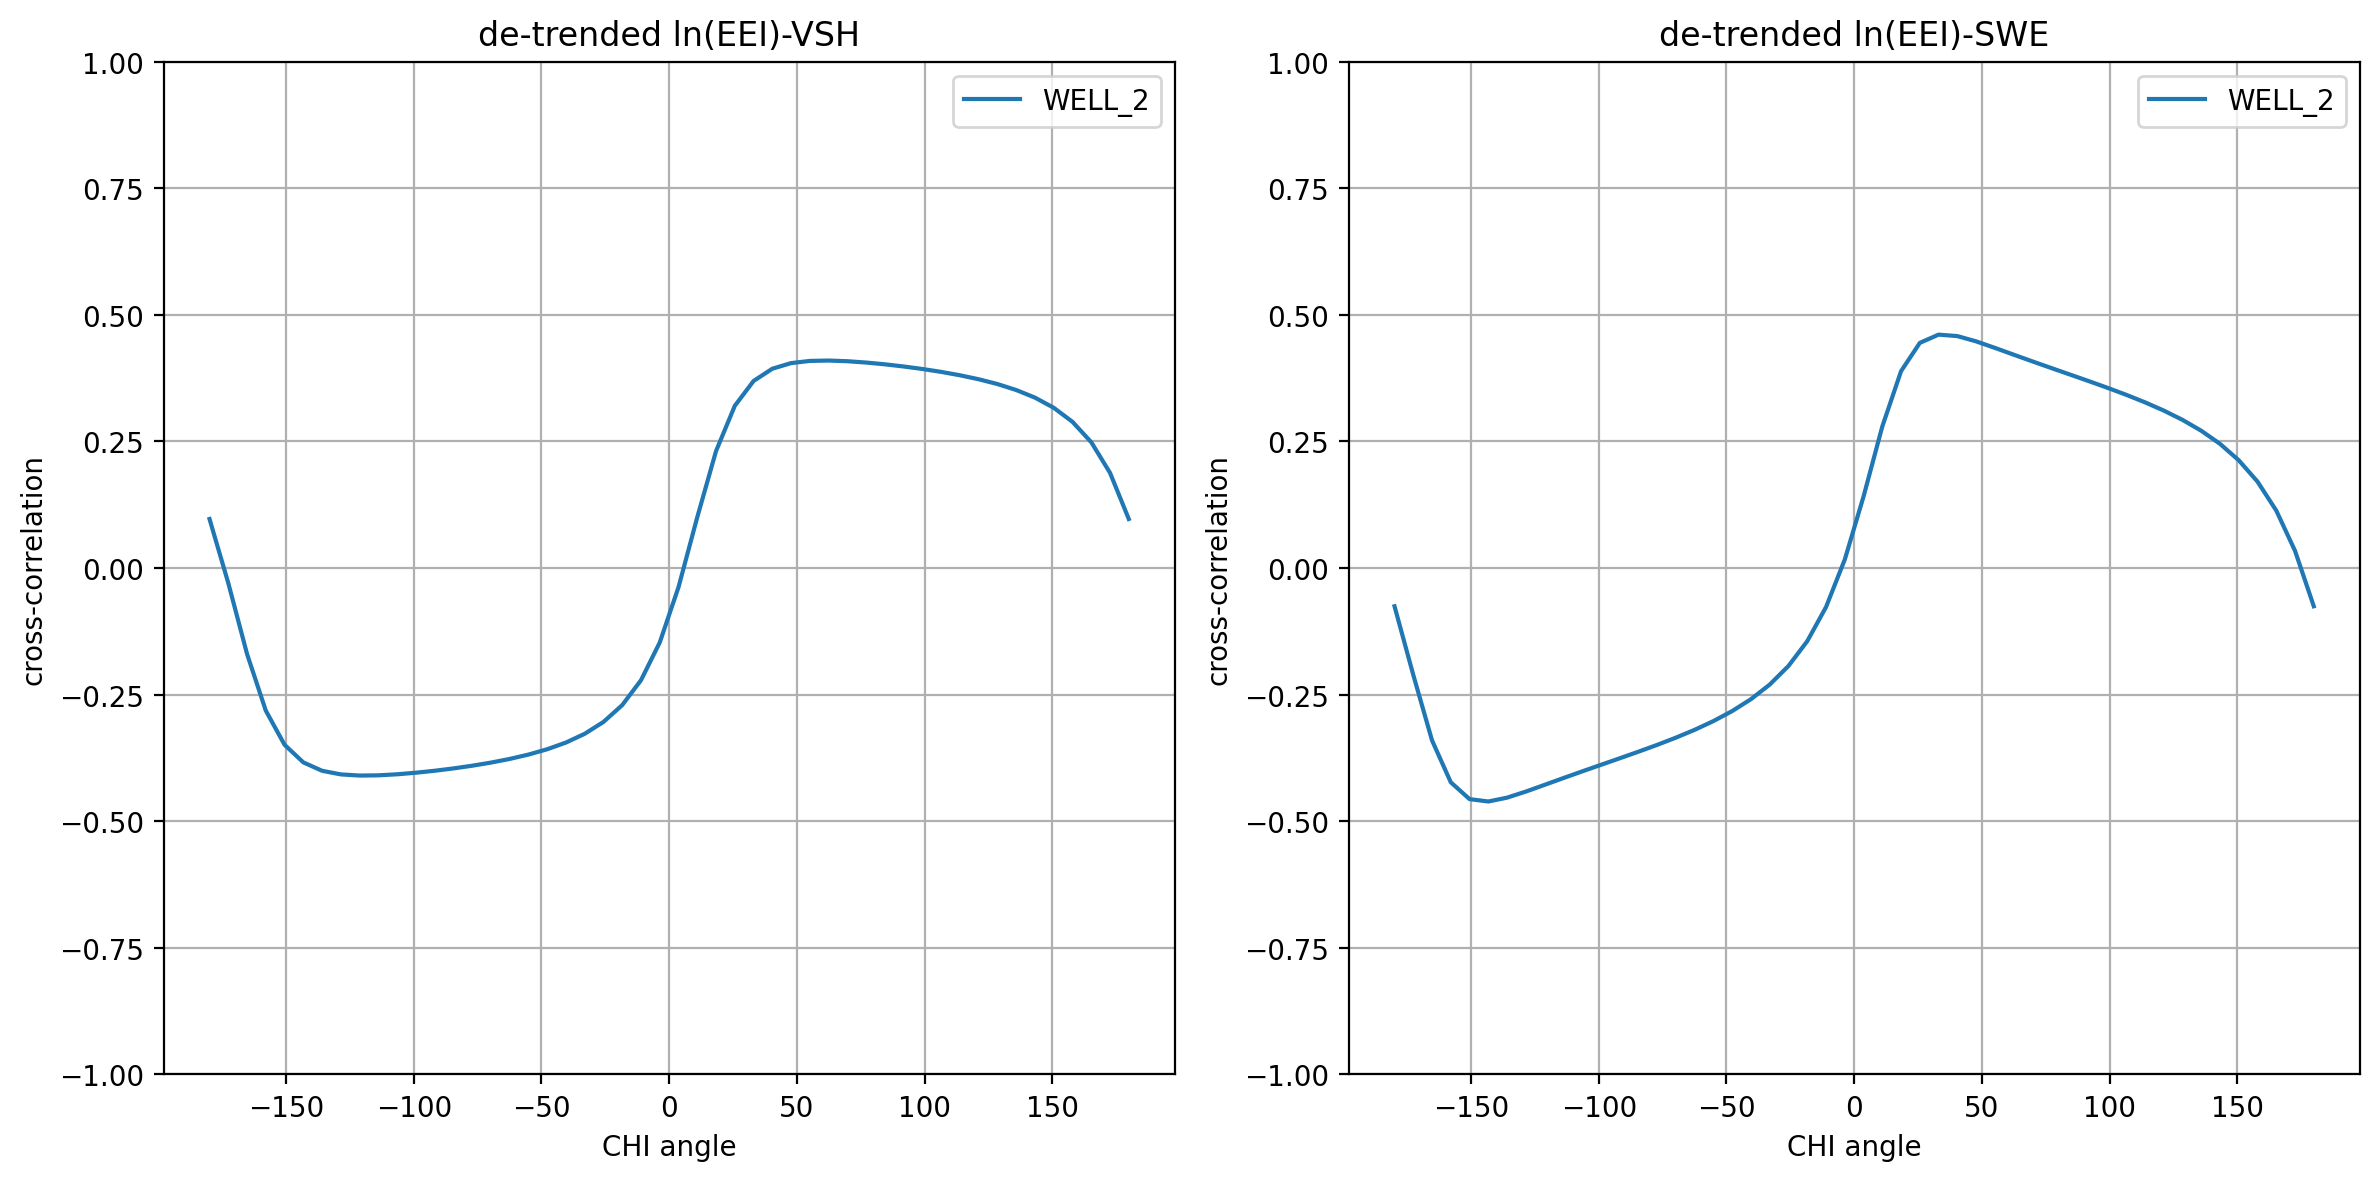

In [18]:
print('input: EEI, trend removal=No')
eei_optimalchi(wells,names,markers,'top_sand',100,scal0,k0,chi_min=-180,chi_max=180,ln=False,brine=False,removetrend=False)
print('input: EEI, trend removal=Yes')
eei_optimalchi(wells,names,markers,'top_sand',100,scal0,k0,chi_min=-180,chi_max=180,ln=False,brine=False,removetrend=True)
print('input: ln(EEI), trend removal=Yes')
eei_optimalchi(wells,names,markers,'top_sand',100,scal0,k0,chi_min=-180,chi_max=180,ln=True,brine=False,removetrend=True)

Finally, the `eei_scanlogs` function plots the target logs, i.e. the lithology and fluid logs (`VSH` and `SWE` respectively) with EEI curves at different angles superimposed.

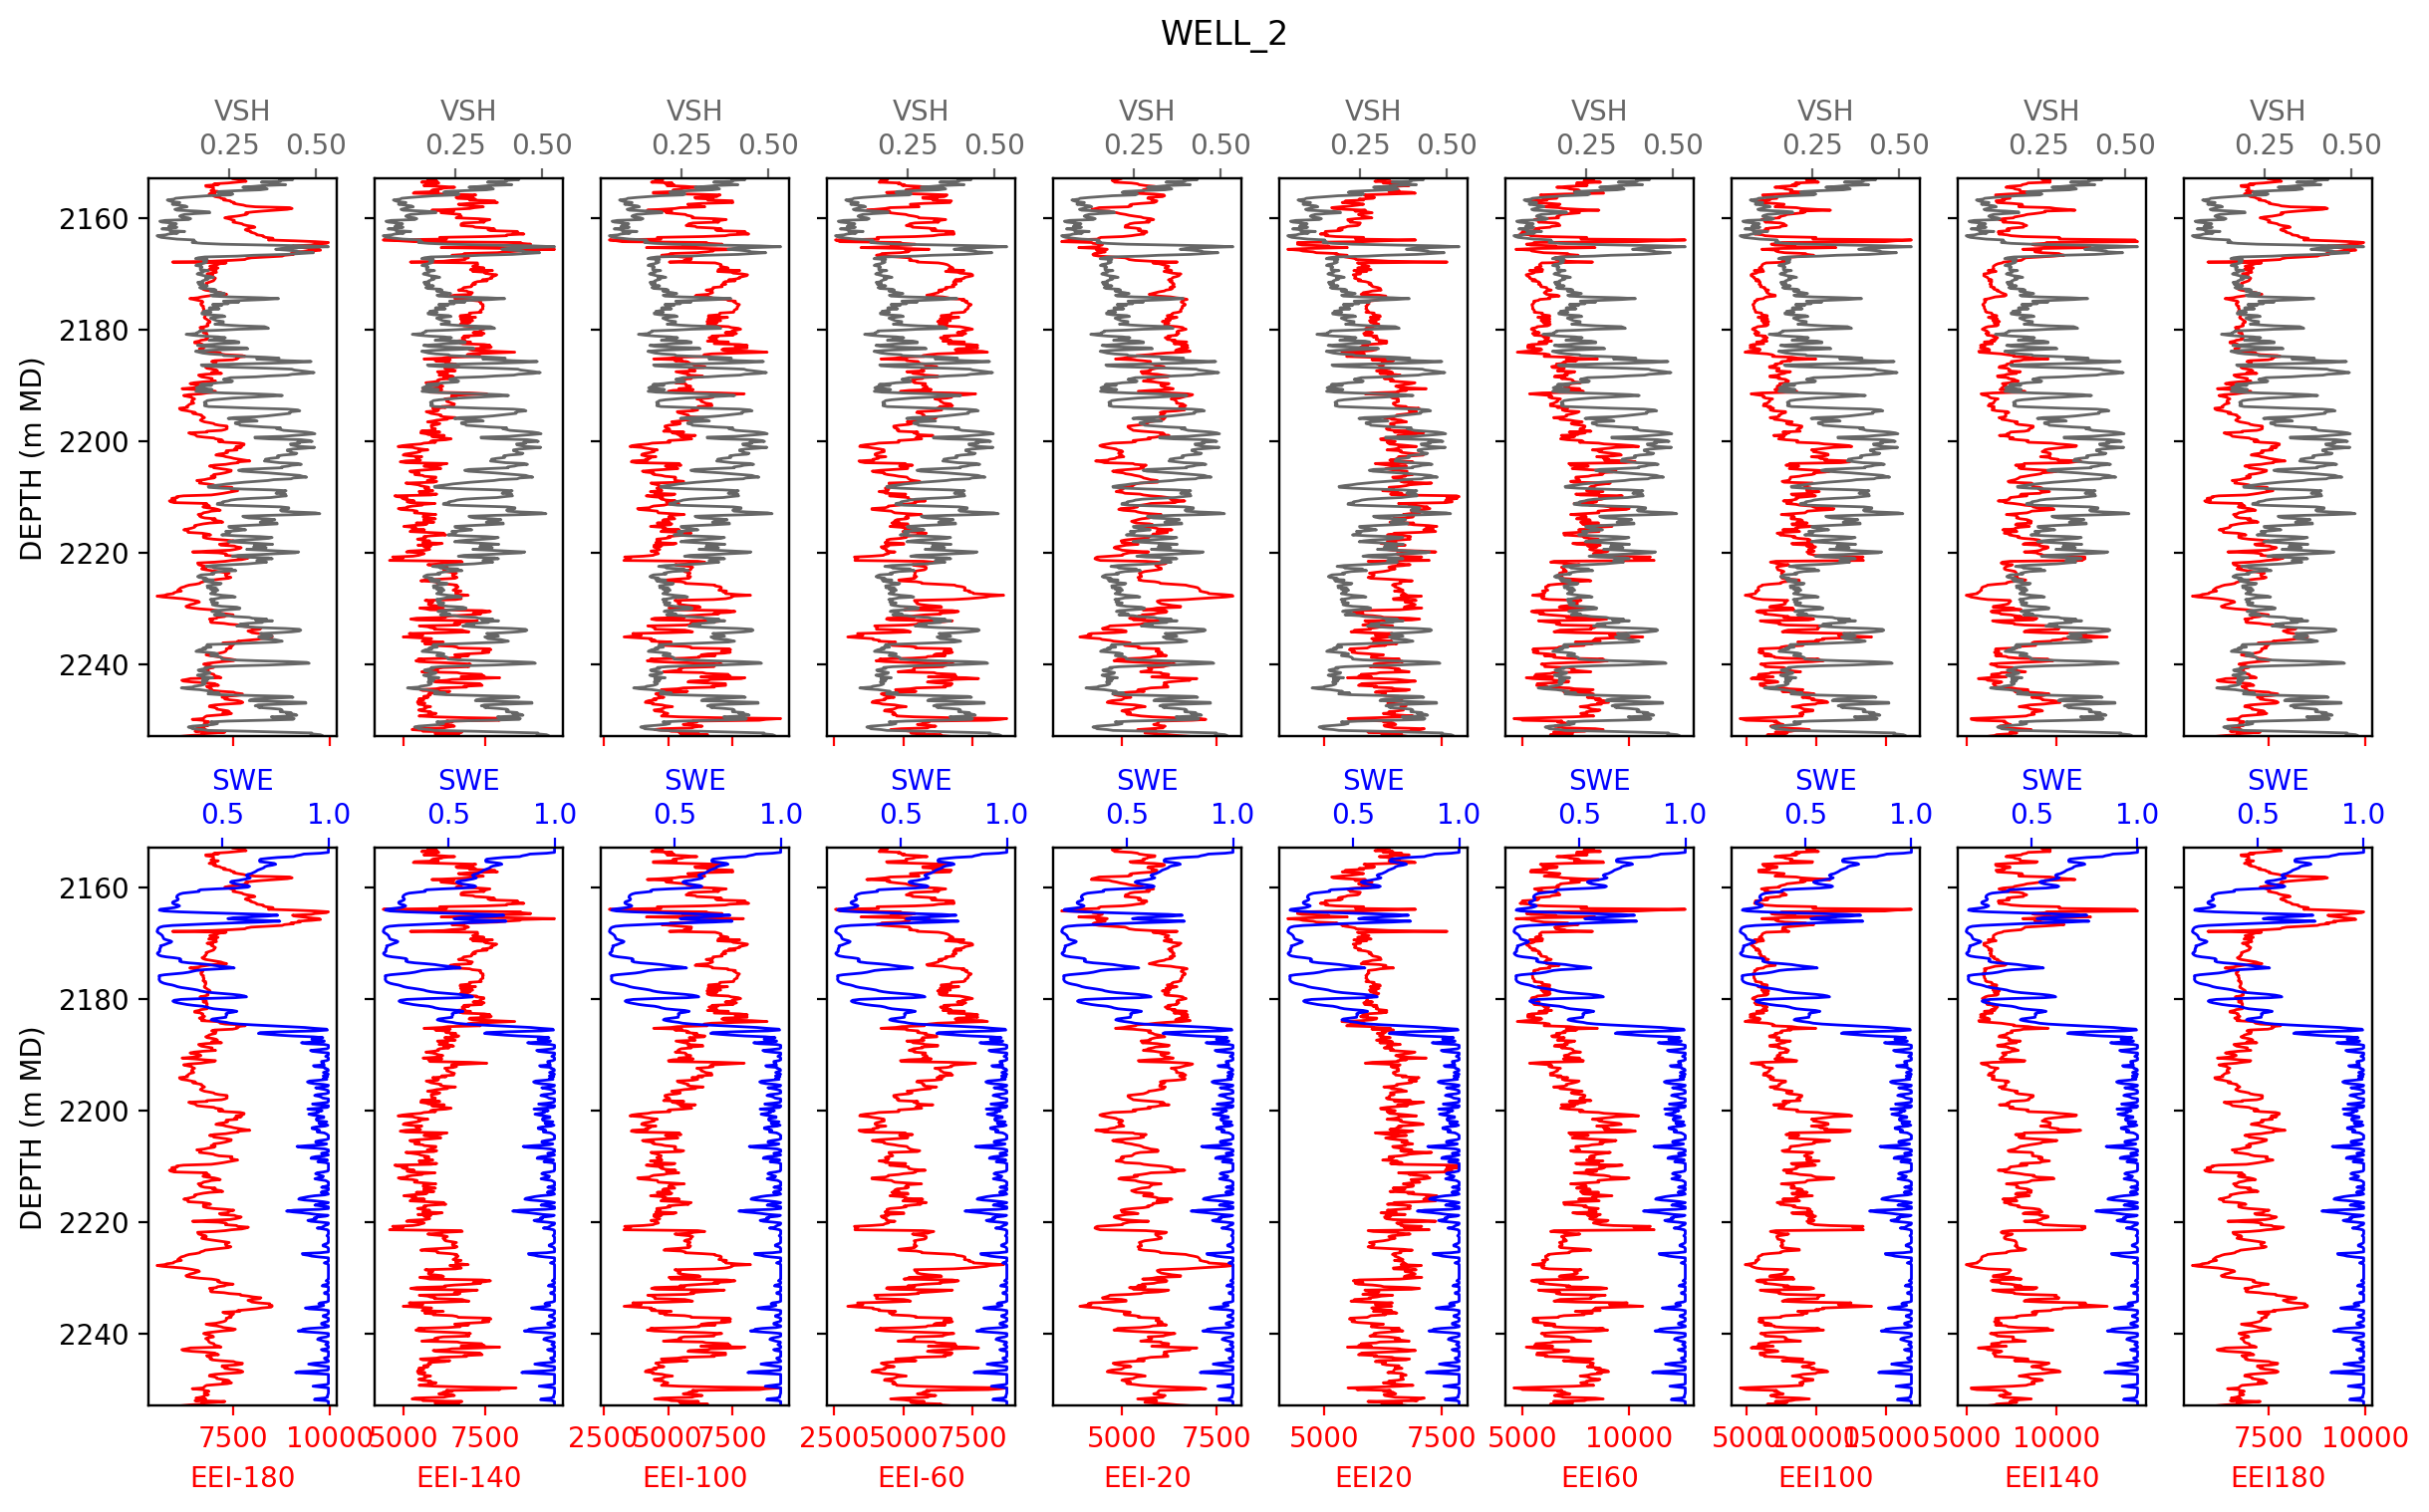

In [19]:
eei_scanlogs(wells,names,markers,'top_sand',100,scal0,k0,chi_min=-180,chi_max=180,brine=False,removetrend=False)

## interactive parameters exploration

In [25]:
def eei_optimalchi_interactive(filename,depth_range,scal,k,ln=False,brine=False,litholog='VSH',fluidlog='SWE',removetrend=False):
    ww=pd.read_csv(filename, index_col=0) 
    label_eei = 'EEI'
    if ln:
        label_eei = 'ln('+label_eei+')'
    if removetrend:
        label_eei = 'de-trended '+label_eei
    if brine:
        idvp,idvs,idrho=['VP_FRMB','VS_FRMB','RHO_FRMB']
    else:
        idvp,idvs,idrho=['VP','VS','RHO']
    chi=np.linspace(-180,180)
    corr_litho, corr_fluid = (np.zeros(chi.size) for _ in range(2))
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
    z1 = depth_range[0]
    z2 = depth_range[1]
    ww = ww.loc[(ww.index>=z1) & (ww.index<=z2)]
    ww = ww.interpolate(limit_direction='both')
    litho,fluid=ww[litholog],ww[fluidlog]
    for n,X in enumerate(chi):
        eei = calc_eei(ww[idvp],ww[idvs],ww[idrho],X,scal=scal,k=k)
        if ln:
            eei = np.log(eei)
        if removetrend:
            eei = pd.Series(data=detrend(eei), index=ww.index)
            litho = pd.Series(data=detrend(litho), index=ww.index)
            fluid = pd.Series(data=detrend(fluid), index=ww.index)
        corr_litho[n]=litho.corr(eei)
        corr_fluid[n]=fluid.corr(eei)
    maxcorr_litho = np.max(np.abs(corr_litho))
    maxcorr_litho_id=np.argmax(np.abs(corr_litho))
    maxcorr_fluid = np.max(np.abs(corr_fluid))
    maxcorr_fluid_id=np.argmax(np.abs(corr_fluid))
    print('Litho: max corr. EEI={:.2f} @ X={:.0f}'.format(maxcorr_litho,chi[maxcorr_litho_id]))
    print('Fluid: max corr. EEI={:.2f} @ X={:.0f}'.format(maxcorr_fluid,chi[maxcorr_fluid_id]))
    ax[0].plot(chi,corr_litho)
    ax[1].plot(chi,corr_fluid)
    ax[0].set_title('{}-{}'.format(label_eei,litholog))
    ax[1].set_title('{}-{}'.format(label_eei,fluidlog))
    for aa in ax:
        aa.grid()
        aa.set_xlabel('CHI angle'), aa.set_ylabel('cross-correlation')
        aa.set_ylim(-1,1)
    plt.tight_layout()

In [30]:
pd.read_csv('qsiwell2_frm.csv')

,DEPTH,VP,VS,RHO_OLD,GR,NPHI,RHO,SWE,SWX,VPVS,...,K_FRMB,K_DRY,VP_FRMO,VS_FRMO,RHO_FRMO,K_FRMO,VP_FRMG,VS_FRMG,RHO_FRMG,K_FRMG
0,2013.2528,2294.7,876.9,1.9972,91.8785,0.4908,NaN,NaN,NaN,2.616832,...,NaN,NaN,2294.7,876.9,NaN,NaN,2294.7,876.9,NaN,NaN
1,2013.4052,2296.7,943.0,2.0455,86.8004,0.4833,2.240104,1.0,1.0,2.435525,...,9.160156,4.096159,2296.7,943.0,2.240104,6.084761,2296.7,943.0,2.240104,4.243140
2,2013.5576,2290.4,912.5,2.1122,86.0021,0.4474,2.242288,1.0,1.0,2.510027,...,9.273484,4.199001,2290.4,912.5,2.242288,6.190247,2290.4,912.5,2.242288,4.346112
3,2013.7100,2277.5,891.6,2.1960,87.3570,0.4140,2.242800,1.0,1.0,2.554397,...,9.256197,4.299676,2277.5,891.6,2.242800,6.244314,2277.5,891.6,2.242800,4.443330
4,2013.8624,2262.0,890.5,2.2020,90.4024,0.4293,2.240064,1.0,1.0,2.540146,...,9.093145,4.350009,2262.0,890.5,2.240064,6.210902,2262.0,890.5,2.240064,4.487475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4112,2639.9216,3786.8,1795.4,2.3972,59.1847,0.0873,2.399544,1.0,1.0,2.109168,...,24.096000,22.949694,3786.8,1795.4,2.399544,23.356446,3786.8,1795.4,2.399544,22.978117
4113,2640.0740,3786.8,1795.4,2.3972,59.1847,0.0873,2.399544,1.0,1.0,2.109168,...,24.096000,22.949694,3786.8,1795.4,2.399544,23.356446,3786.8,1795.4,2.399544,22.978117
4114,2640.2263,3974.8,1795.4,2.3972,59.1847,0.0873,2.399544,1.0,1.0,2.213880,...,27.597370,27.264003,3974.8,1795.4,2.399544,27.377573,3974.8,1795.4,2.399544,27.271780
4115,2640.3789,3974.8,1795.4,2.3972,59.1847,0.0873,2.399544,1.0,1.0,2.213880,...,27.597370,27.264003,3974.8,1795.4,2.399544,27.377573,3974.8,1795.4,2.399544,27.271780


In [29]:
interact(eei_optimalchi_interactive,filename='qsiwell2_frm.csv',
         depth_range=widgets.FloatRangeSlider(value=[2100, 2300],min=2050,max=2400.0,step=10,description='depth range',
         continuous_update=False,orientation='horizontal',readout=True,readout_format='.0f'),
         scal=fixed(scal0),k=fixed(k0),
         ln=widgets.Checkbox(value=False,description='Logarithm EEI'),
         brine=widgets.Checkbox(value=False,description='Use brine-replaced logs'),
         removetrend=widgets.Checkbox(value=False,description='Remove trend'),
         litholog=fixed('VSH'),fluidlog=fixed('SWE'));

interactive(children=(Text(value='qsiwell2_frm.csv', description='filename'), FloatRangeSlider(value=(2100.0, …

In [31]:
ggg={'Gamma Ray':'GR','Shale Volumerosity':'PHIE','Water Saturation':'SWE'}
interact(eei_diagnostic,ww=fixed(w2),ztop=(2000,2100,10),zbot=(2300,2400,10),scal=fixed(scal0),k=fixed(k0),
         ln=widgets.Checkbox(value=False,description='Logarithm EEI'),
         brine=widgets.Checkbox(value=False,description='Use brine-replaced logs'),
         removetrend=widgets.Checkbox(value=False,description='Remove trend'),
         chi_min=fixed(-180),chi_max=fixed(180),name=fixed('EEI Diagnostic'),
         targetlog=widgets.RadioButtons(options=ggg,description='Target log'));

interactive(children=(IntSlider(value=2050, description='ztop', max=2100, min=2000, step=10), IntSlider(value=…